In [23]:
import pandas as pd
import numpy as np
import json

In [24]:
xls = pd.ExcelFile('models/Hermen/herman_draft_template.xlsx')
print(xls.sheet_names)

['food', 'animal', 'animalT', 'manure', 'crops', 'LU', 'nutrient', 'scalar']


In [25]:
data = {}

# manual parse

In [26]:
df = xls.parse("food", index_col=0)
for col in df.columns:
    data[col] = {}
    data[col]['data'] = df[col].to_dict()
    data[col]['id'] = col    
    data[col]['name'] = None
    data[col]['unit'] = None
    data[col]['year'] = 2017

In [27]:
df = xls.parse("animal", index_col=0)
for col in ['FCRi', 'AYi', 'ANPi']:
    data[col] = {}
    data[col]['data'] = df[col].to_dict()
    data[col]['id'] = col
    data[col]['name'] = None
    data[col]['unit'] = None
    data[col]['year'] = 2017

In [28]:
df = xls.parse("animalT", index_col=0).dropna()
for col in ['TAHi']:
    data[col] = {}
    data[col]['data'] = df[col].to_dict()
    data[col]['id'] = col
    data[col]['name'] = None
    data[col]['unit'] = None
    data[col]['year'] = 2017

In [29]:
df = xls.parse("manure", index_col=0)

for col in df.columns:
    if col != 'Item':
        data[col] = {}
        data[col]['data'] = df[col].to_dict()
        data[col]['id'] = col
        data[col]['name'] = None
        data[col]['unit'] = None
        data[col]['year'] = 2017

In [30]:
df = xls.parse("crops", index_col=0)
for col in df.columns:
    if col != 'Item':
        data[col] = {}
        data[col]['data'] = df[col].to_dict()
        data[col]['id'] = col
        data[col]['name'] = None
        data[col]['unit'] = None
        data[col]['year'] = 2017

In [31]:
df = xls.parse("LU", index_col=0)
for col in df.columns:
    if col != 'Item':
        data[col] = {}
        data[col]['data'] = df[col].to_dict()
        data[col]['id'] = col
        data[col]['name'] = None
        data[col]['unit'] = None
        data[col]['year'] = 2017

In [32]:
df = xls.parse("nutrient")
for col in df.columns:
    data[col] = {}
    data[col]['data'] = {'Value': int(df[col].values[0])}
    data[col]['id'] = col
    data[col]['name'] = None
    data[col]['unit'] = None
    data[col]['year'] = 2017


In [34]:
df = xls.parse('scalar')
for col in df.columns:
    data[col] = {}
    data[col]['data'] = {'Value': int(df[col].values[0])}
    data[col]['id'] = col
    data[col]['name'] = None
    data[col]['unit'] = None
    data[col]['year'] = 2017


In [38]:
for key in data['FWPPi']['data']:
    data['FWPPi']['data'][key] = 100

In [40]:
with open('models/Hermen/LandUse_parameters.json', 'w') as f:
    json.dump(data, f, indent=4)

# test on model

In [16]:
from graphmodels.utils import parse_parameter_json
from graphmodels.graphmodel import GraphModel

In [17]:
import pandas as pd
import numpy as np


feed_demand = ['Cereals - Excluding Beer', 'Starchy Roots', 'Sugar Crops', 'Sugar & Sweeteners', 'Pulses',
               'Treenuts', 'Oilcrops', 'Vegetable Oils', 'Vegetables', 'Fruits - Excluding Wine',
               'Stimulants', 'Spices', 'Alcoholic Beverages']

croPgroups = ['Cereals - Excluding Beer', 'Fruits - Excluding Wine', 'Oilcrops',
               'Pulses', 'Starchy Roots', 'Sugar Crops', 'Treenuts', 'Vegetables']

animal_products_1 = ['Bovine meat', 'Pigmeat', 'Poultry meat',
                     'Eggs', 'Milk - Excluding Butter', 'Meat, other']

animal_products_2 = ['Bovine meat', 'Mutton & Goat meat', 'Pigmeat', 'Poultry meat', 'Meat, other', 'Offals',
                     'Animal fats', 'Eggs', 'Milk - Excluding Butter', 'Fish, Seafood', 'Aquatic Products, Other',
                     'Miscellaneous']

graph_nodes0 = [
    {'type': 'variable',  # Type of node (input, output, variable, parameter)
     'unit': '',  # Unit
     'id': 'CRfd',  # Unique code to define the node
     'name': 'feed/forage distribution (correction)',  # Full name
     'in': ['TAFDi_cal', 'FDi'],  # Specify what comes into the node
     'computation': {'name': 'SUM(TAFDi)/sum(FDi)',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: X['TAFDi_cal'].sum() / X['FDi'].sum()}  # For now leave the formula field empty

     },
    {'type': 'variable',
     'id': 'TFFD_',
     'name': 'Total fodder/forage demand',
     'unit': 'x 1000t',
     'in': ['FDi', 'TAFDi_cal'],  # Specify what comes into the node
     'computation': {'name': 'SUM(TAFDi_cal) - SUM(FDi)',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: X['TAFDi_cal'].sum() - X['FDi'].sum()}  # For now leave the formula field empty
     },
    {'type': 'input',  # Type of node (input, output, variable, parameter)
     'unit': '1000 t',  # Unit
     'id': 'FDi',  # Unique code to define the node
     'name': 'Vector feed demand',  # Full name

     },
    {'type': 'variable',  # Type of node (input, output, variable, parameter)
     'unit': 'kg',  # Unit
     'id': 'TAFDi_cal',  # Unique code to define the node
     'name': 'vector total animal feed demand',  # Full name
     'in': ['FCRi', 'AYi', 'ANPi_cal'],  # Specify what comes into the node
     'computation': {'name': '(FRCi*AYi*ANPi_cal)/1000000',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: 1e-6 * (X['FCRi'] * X['AYi']).loc[animal_products_1] * X['ANPi_cal']}  # For now leave the formula field empty
     },
    {'type': 'input',  # Type of node (input, output, variable, parameter)
     'unit': 'kg/animal',  # Unit
     'id': 'AYi',  # Unique code to define the node
     'name': 'Vector of animal yields',  # Full name

     },
    {'type': 'parameter',  # Type of node (input, output, variable, parameter)
     'unit': 'kg DM feed/ kg EW',  # Unit
     'id': 'FCRi',  # Unique code to define the node
     'name': 'feed conversion ratio (kg/animal)',  # Full name

     },
    {'type': 'variable',
     'unit': 'heads',
     'id': 'ANPi_cal',
     'name': 'Vector animals needed for production',
     'in': ['FDi_an', 'AYi'],
     'computation': {'name': '(FDi_an*1000000)/AYi',
                     'formula': lambda X: 1e6 * X['FDi_an'] / X['AYi'].loc[animal_products_1]}

     },
    {'type': 'variable',  # Type of node (input, output, variable, parameter)
     'unit': 'heads',  # Unit
     'id': 'FDi_an',  # Unique code to define the node
     'name': 'selection animal-based food groups',  # Full name
     'in': ['FDTi_animal'],  # Specify what comes into the nod
     'computation': {'name': 'Selection animal-based food groups',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: np.array([X['FDTi_animal'][0], X['FDTi_animal'][2], X['FDTi_animal'][3], X['FDTi_animal'][7],
                                                    X['FDTi_animal'][8], (X['FDTi_animal'][1] + X['FDTi_animal'][4])])}  # selects the food groups that are animal based
     },
    {'type': 'output',
     'id': 'FDTi_animal',
     'name': 'Vector total food demand (animals/other)',
     'unit': 'x 1000 tonne',
     'in': ['FPi'],  # Specify what comes into the node
     'computation': {'name': 'FPi selection animal products',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: X['FPi'].loc[animal_products_2]}  # For now leave the formula field empty
     },
    {'type': 'input',  # Type of node (input, output, variable, parameter)
     'unit': '1000 t',  # Unit
     'id': 'FPi',  # Unique code to define the node
     'name': 'Vector food production',  # Full name
     },
    # CD_corr calibration
    # Here the food demand model is copied &  is used to compute correction for crop land demand
    # The model drivers (i.e. population, food waste reduction policies) removed so this parameter doesn't change for simulated years (not tested yet)
    # new variable: P used for population in , now 'P' can be used as normal


    # update 8-12-2020: the land demand for crops is now calculated by taking cropland [4] -  land under permanent crops [9]

    {'type': 'variable',  # Type of node (input, output, variable, parameter)
     'unit': '',  # Unit
     'id': 'CD_corr',  # Unique code to define the node
     'name': 'correction parameter crop demand (calibrated for )',  # Full name
     'in': ['TCropDi_cal', 'TCLi'],  # Specify what comes into the node
     'computation': {'name': '',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: (X['LUi'].loc['Cropland'] \
                                           - X['LUi'].loc['Land under permanent crops']) \
                     / (X['TCropDi_cal'].sum() * 1e-3)}  # For now leave the formula field empty
     },
    {'type': 'variable',  # Type of node (input, output, variable, parameter)
     'unit': 'ha',  # Unit
     'id': 'TCropDi_cal',  # Unique code to define the node
     'name': 'Vector total cropland demand',  # Full name
     'in': ['FDTi_conv_cal', 'CYi'],  # Specify what comes into the node
     'computation': {'name': '(FDTi_conv_cal*1000000/(CYi/10)',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: (X['FDTi_conv_cal'] * 1e6) / (X['CYi'] * 1e-1)}  # For now leave the formula field empty
     },
    {'type': 'variable',  # Type of node (input, output, variable, parameter)
     'unit': 'x 1000t',  # Unit
     'id': 'FDTi_conv_cal',  # Unique code to define the node
     'name': 'Vector total food demand (aggregated for each crop group)',  # Full name
     'in': ['FDTi_total_cal', 'CYi', 'TCLi'],  # Specify what comes into the node
     'computation': {'name': '',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: pd.concat([X['FDTi_total_cal'].loc[croPgroups],
                                                     (X['CYi'] * 1e-6 * 1e-1 * X['TCLi']).loc[['Fibre Crops Primary']]])}  # For now leave the formula field empty
     },
    {'type': 'input',  # Type of node (input, output, variable, parameter)
     'unit': 'ha',  # Unit
     'id': 'TCLi',  # Unique code to define the node
     'name': 'Vector land used for crops in ',  # Full name
     },
    {'type': 'input',  # Type of node (input, output, variable, parameter)
     'unit': 'kg/capita/yr',  # Unit
     'id': 'FDKGi',  # Unique code to define the node
     'name': 'Vector KG food demand',  # Full name
     },
    {'type': 'input',  # Type of node (input, output, variable, parameter)
     'unit': 'kcal/capita/day',  # Unit
     'id': 'FDKCi',  # Unique code to define the node
     'name': 'Vector of KCAL food demand',  # Full name
     },
    {'type': 'input',  # Type of node (input, output, variable, parameter)
     'unit': 'hg/ha',  # Unit
     'id': 'CYi',  # Unique code to define the node
     'name': 'Vector crop yields',  # Full name
     },
    {'type': 'variable',
     'id': 'KKRi',
     'name': 'Vector Kcal/kg ratio ',
     'unit': 'Kcal/kg',
     'in': ['FDKGi', 'FDKCi'],  # Specify what comes into the node
     'computation': {'name': 'FDKCi/(FDKGi/365)',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: (X['FDKCi'] / (X['FDKGi'] / 365))}  # For now leave the formula field empty

     },
    {'type': 'variable',  # Type of node (input, output, variable, parameter)
     'unit': '%',  # Unit
     'id': 'SSRi',  # Unique code to define the node
     'name': 'Self-sufficiency ratio',  # Full name
     'in': ['FPi', 'FEi', 'FIi'],  # Specify what comes into the node
     'computation': {'name': '100*FPi/(FPi-FEi+FIi)',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: (1e2 * X['FPi']) / (X['FPi'] - X['FEi'] + X['FIi'])}  # For now leave the formula field empty
     },
    {'type': 'input',  # Type of node (input, output, variable, parameter)
     'unit': '1000 t',  # Unit
     'id': 'FPi',  # Unique code to define the node
     'name': 'Vector food production',  # Full name
     },
    {'type': 'input',  # Type of node (input, output, variable, parameter)
     'unit': '1000 t',  # Unit
     'id': 'FEi',  # Unique code to define the node
     'name': 'Vector food exports',  # Full name
     },
    {'type': 'input',  # Type of node (input, output, variable, parameter)
     'unit': '1000 t',  # Unit
     'id': 'FIi',  # Unique code to define the node
     'name': 'Vector food imports',  # Full name
     },
    {'type': 'input',  # Type of node (input, output, variable, parameter)
     'unit': 'population',  # Unit
     'id': 'P',  # Unique code to define the node
     'name': 'Total population',  # Full name
     },
    {'type': 'input',  # Type of node (input, output, variable, parameter)
     'unit': 'x 1000 t',  # Unit
     'id': 'FLOi',  # Unique code to define the node
     'name': 'Food losses',  # Full name
     },
    {'type': 'variable',  # Type of node (input, output, variable, parameter)
     'unit': 'kcal/cap/day',  # Unit
     'id': 'FWPi_cal',  # Unique code to define the node
     'name': 'Vector food waste ',  # Full name
     'in': ['FLOi', 'P', 'KKRi'],  # Specify what comes into the node
     'computation': {'name': '(FLOi*KKRi*(1000000/365))/P',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: (X['FLOi'] * X['KKRi'] * (1e6 / 365)) / X['P']}  # For now leave the formula field empty
     },
    {'type': 'variable',  # Type of node (input, output, variable, parameter)
     'unit': 'heads',  # Unit
     'id': 'ANPi_calc',  # Unique code to define the node
     'name': 'Vector animals needed for production',  # Full name
     'in': ['FDi_an', 'AYi'],  # Specify what comes into the node
     'computation': {'name': '(FDi_an*1000000)/AYi',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: (X['FDi_an'] * 1e6) / X['AYi'].loc[animal_products_1]}  # For now leave the formula field empty

     },
    {'type': 'variable',  # Type of node (input, output, variable, parameter)
     'unit': '1000 t',  # Unit
     'id': 'FDi_cal',  # Unique code to define the node
     'name': 'Vector total domestic food production',  # Full name
     'in': ['KKRi', 'SSRi', 'TCDi_cal'],  # Specify what comes into the node
     'computation': {'name': '(TCDi_cal * SSRi/100 * 365)/KKRi',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: (X['TCDi_cal'] * X['SSRi'] / 1e2 * 365) / X['KKRi']}  # For now leave the formula field empty
     },
    {'type': 'variable',  # Type of node (input, output, variable, parameter)
     'unit': '1000 t',  # Unit
     'id': 'OFi',  # Unique code to define the node
     'name': 'Other food demand',  # Full name
     'in': ['SDi', 'NFDi', 'PDi', 'RDi', 'SVi'],  # Specify what comes into the node
     'computation': {'name': 'SDi+NFDi+PDi+RDi+SVi',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: X['SDi'] + X['NFDi'] + X['PDi'] + X['RDi'] + X['SVi']}  # For now leave the formula field empty
     },

    {'type': 'input',  # Type of node (input, output, variable, parameter)
     'unit': '1000 t',  # Unit
     'id': 'SDi',  # Unique code to define the node
     'name': 'Vector seed demand',  # Full name
     },

    {'type': 'input',  # Type of node (input, output, variable, parameter)
     'unit': '1000 t',  # Unit
     'id': 'NFDi',  # Unique code to define the node
     'name': 'Vector non-food demand',  # Full name
     },
    {'type': 'input',  # Type of node (input, output, variable, parameter)
     'unit': '1000 t',  # Unit
     'id': 'PDi',  # Unique code to define the node
     'name': 'Vector processed demand',  # Full name
     },
    {'type': 'input',  # Type of node (input, output, variable, parameter)
     'unit': '1000 t',  # Unit
     'id': 'RDi',  # Unique code to define the node
     'name': 'Vector residual demand',  # Full name
     },
    {'type': 'input',  # Type of node (input, output, variable, parameter)
     'unit': '1000 t',  # Unit
     'id': 'SVi',  # Unique code to define the node
     'name': 'Vector stock variation',  # Full name
     },
    {'type': 'variable',  # Type of node (input, output, variable, parameter)
     'unit': 'kcal/day',  # Unit
     'id': 'TCDi_cal',  # Unique code to define the node
     'name': 'Total calorie demand per food group calibrated for ',  # Full name
     'in': ['P', 'FWPi_cal', 'FDKCi'],  # Specify what comes into the node
     'computation': {'name': 'P*(FDKCi+FWPi_cal)',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: X['P'] * (X['FDKCi'] + X['FWPi_cal'])}  # For now leave the formula field empty
     },
    {'type': 'variable',  # Type of node (input, output, variable, parameter)
     'unit': '1000 t',  # Unit
     'id': 'AFDi',  # Unique code to define the node
     'name': 'Vector total animal feed demand',  # Full name
     'in': ['FMi', 'FD'],  # Specify what comes into the node
     'computation': {'name': 'FMi * FD',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: X['FMi'].loc[feed_demand] * X['FD']}  # For now leave the formula field empty
     },
    {'type': 'variable',  # Type of node (input, output, variable, parameter)
     'unit': '',  # Unit
     'id': 'FMi',  # Unique code to define the node
     'name': 'Feed mix fraction',  # Full name
     'in': ['FDi'],  # Specify what comes into the node
     'computation': {'name': 'FDi/SUM(FDI)',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: X['FDi'] / X['FDi'].sum()}  # For now leave the formula field empty
     },
    {'type': 'input',  # Type of node (input, output, variable, parameter)
     'unit': '1000 t',  # Unit
     'id': 'FDi',  # Unique code to define the node
     'name': 'Vector feed demand',  # Full name

     },
    {'type': 'variable',  # Type of node (input, output, variable, parameter)
     'unit': '1ooo t',  # Unit
     'id': 'FD',  # Unique code to define the node
     'name': 'Total crop-feed demand',  # Full name
     'in': ['TAFDi', 'CRfd'],  # Specify what comes into the node
     'computation': {'name': 'SUM(TAFDi)/CRfd',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: X['TAFDi'].sum() / X['CRfd']}  # For now leave the formula field empty
     },
    {'type': 'input',  # Type of node (input, output, variable, parameter)
     'unit': '',  # Unit
     'id': 'LUi',  # Unique code to define the node
     'name': '',  # Full name
     },
    {'type': 'variable',  # Type of node (input, output, variable, parameter)
     'unit': 'kg',  # Unit
     'id': 'TAFDi',  # Unique code to define the node
     'name': 'vector total animal feed demand',  # Full name
     'in': ['FCRi', 'AYi', 'ANPi_calc'],  # Specify what comes into the node
     'computation': {'name': '(FRCi*AYi*ANPi_calc)/1000000',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: (X['FCRi'] * X['AYi']).loc[animal_products_1] * X['ANPi_calc'] * 1e-6}  # For now leave the formula field empty
     },
    {'type': 'input',  # Type of node (input, output, variable, parameter)
     'unit': 'kg/animal',  # Unit
     'id': 'AYi',  # Unique code to define the node
     'name': 'Vector of animal yields',  # Full name

     },
    {'type': 'parameter',  # Type of node (input, output, variable, parameter)
     'unit': 'kg DM feed/ kg EW',  # Unit
     'id': 'FCRi',  # Unique code to define the node
     'name': 'feed conversion ratio (kg/animal)',  # Full name

     },
    {'type': 'output',
     'id': 'FDTi_crops_cal',
     'name': 'Vector total food demand (crops)',
     'unit': 'x 1000 tonne',
     'in': ['FDi_cal', 'OFi', 'AFDi', 'SSRi'],  # Specify what comes into the node
     'computation': {'name': 'SSRi/100*(OFi+AFDi)+FDi',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: (((X['SSRi'] * 1e-2) * (X['OFi'] + X['AFDi'])) + (X['FDi_cal'] * 1e-6)).loc[feed_demand]}  # For now leave the formula field empty
     },
    {'type': 'output',
     'id': 'FDTi_animal',
     'name': 'Vector total food demand (animals/other)',
     'unit': 'x 1000 tonne',
     'in': ['FDi_cal', 'OFi', 'FDi', 'SSRi'],  # Specify what comes into the node
     'computation': {'name': 'SSRi/100*(OFi+AFDi)+FDi',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: (((X['SSRi'] * 1e-2) * (X['OFi'] + X['FDi'])) + X['FDi_cal']).loc[animal_products_2] * 1e-6}  # For now leave the formula field empty
     },
    {'type': 'output',
     'id': 'FDTi_total_cal',
     'name': 'Vector total food demand all',
     'unit': 'x 1000 tonne',
     'in': ['FDTi_animal', 'FDTi_crops_cal'],  # Specify what comes into the node
     'computation': {'name': 'concatenate FDTi_animal and FDTi_crops_cal',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: pd.concat((X['FDTi_crops_cal'], X['FDTi_animal']))}  # For now leave the formula field empty
     }
]


In [18]:
ids = [node['id'] for node in graph_nodes0 if node['type'] in ['input', 'parameter']]

In [19]:
parameters = parse_parameter_json('models/Hermen/LandUse_parameters.json')



In [21]:
parameters['AFDi']

Cereals - Excluding Beer       0
Starchy Roots                  0
Sugar Crops                 4160
Sugar & Sweeteners             9
Pulses                         0
Treenuts                       1
Oilcrops                       4
Vegetable Oils                 0
Vegetables                    88
Fruits - Excluding Wine        0
Stimulants                   104
Spices                         2
Alcoholic Beverages            0
Bovine meat                    0
Mutton & Goat meat             0
Pigmeat                        0
Poultry meat                   0
Meat, other                    0
Offals                         0
Animal fats                    0
Eggs                           0
Milk - Excluding Butter        0
Fish, Seafood                  1
Aquatic Products, Other      139
Miscellaneous                 10
dtype: int64

In [22]:
parameters['FDi']

Cereals - Excluding Beer    4160
Starchy Roots                  9
Sugar Crops                    0
Sugar & Sweeteners             1
Pulses                         4
Treenuts                       0
Oilcrops                      88
Vegetable Oils                 0
Vegetables                   104
Fruits - Excluding Wine        2
Stimulants                     0
Spices                         0
Alcoholic Beverages            0
Bovine meat                    0
Mutton & Goat meat             0
Pigmeat                        0
Poultry meat                   0
Meat, other                    0
Offals                         0
Animal fats                    0
Eggs                           1
Milk - Excluding Butter      139
Fish, Seafood                 10
Aquatic Products, Other        0
Miscellaneous                  0
dtype: int64

In [20]:
with open('models/Hermen/LandUse_parameters.json', 'r') as f:
    para = json.load(f)

In [16]:
parameters = {ID: parameters[ID] for ID in ids}

G = GraphModel(graph_nodes0)
X = G.run(parameters, parameters)

NameError: name 'parameters' is not defined

# FOR COLLAB

In [33]:
import graphviz
import pydot

In [34]:
pydot.__version__

'1.4.1'

In [32]:
graphviz.__version__

'0.14.2'

In [55]:
import pandas as pd
import numpy as np


feed_demand = ['Cereals - Excluding Beer', 'Starchy Roots', 'Sugar Crops', 'Sugar & Sweeteners', 'Pulses',
               'Treenuts', 'Oilcrops', 'Vegetable Oils', 'Vegetables', 'Fruits - Excluding Wine',
               'Stimulants', 'Spices', 'Alcoholic Beverages']

croPgroups = ['Cereals - Excluding Beer', 'Fruits - Excluding Wine', 'Oilcrops',
               'Pulses', 'Starchy Roots', 'Sugar Crops', 'Treenuts', 'Vegetables']

animal_products_1 = ['Bovine meat', 'Pigmeat', 'Poultry meat',
                     'Eggs', 'Milk - Excluding Butter', 'Meat, other']

animal_products_2 = ['Bovine meat', 'Mutton & Goat meat', 'Pigmeat', 'Poultry meat', 'Meat, other', 'Offals',
                     'Animal fats', 'Eggs', 'Milk - Excluding Butter', 'Fish, Seafood', 'Aquatic Products, Other',
                     'Miscellaneous']
ayi_products = ["Meat, goat", 'Meat, horse', 'Meat, sheep', 'Meat, rabbit']

refactored= [
    {'type': 'variable',  # Type of node (input, output, variable, parameter)
     'unit': '',  # Unit
     'id': 'CRfd',  # Unique code to define the node
     'name': 'feed/forage distribution (correction)',  # Full name
     'in': ['TAFDi', 'FDi'],  # Specify what comes into the node
     'computation': {'name': 'SUM(TAFDi)/sum(FDi)',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: X['TAFDi'].sum() / X['FDi'].sum()}  # For now leave the formula field empty

     },
    {'type': 'variable',
     'id': 'TFFD',
     'name': 'Total fodder/forage demand',
     'unit': 'x 1000t',
     'in': ['FDi', 'TAFDi'],  # Specify what comes into the node
     'computation': {'name': 'SUM(TAFDi) - SUM(FDi)',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: X['TAFDi'].sum() - X['FDi'].sum()}  # For now leave the formula field empty
     },
    {'type': 'input',  # Type of node (input, output, variable, parameter)
     'unit': '1000 t',  # Unit
     'id': 'FDi',  # Unique code to define the node
     'name': 'Vector feed demand',  # Full name

     },
    {'type': 'input',  # Type of node (input, output, variable, parameter)
     'unit': 'kg/animal',  # Unit
     'id': 'AYi_raw',  # Unique code to define the node
     'name': 'Vector of animal yields',  # Full name

     },
    {'type': 'parameter',  # Type of node (input, output, variable, parameter)
     'unit': 'kg DM feed/ kg EW',  # Unit
     'id': 'FCRi',  # Unique code to define the node
     'name': 'feed conversion ratio (kg/animal)',  # Full name

     },
    {'type': 'variable',
     'unit': 'heads',
     'id': 'ANPi_cal',
     'name': 'Vector animals needed for production',
     'in': ['FDi_an', 'AYi'],
     'computation': {'name': 'FDi_an/AYi',
                     'formula': lambda X: X['FDi_an'] / X['AYi'].loc[animal_products_1]}

     },
    {'type': 'variable',  # Type of node (input, output, variable, parameter)
     'unit': 'heads',  # Unit
     'id': 'FDi_an',  # Unique code to define the node
     'name': 'selection animal-based food groups',  # Full name
     'in': ['FDTi_animal'],  # Specify what comes into the nod
     'computation': {'name': 'Selection animal-based food groups',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: pd.concat([X['FDTi_animal'].loc[['Bovine meat', 'Pigmeat', 'Poultry meat', 'Eggs', 'Milk - Excluding Butter']],
                                                     pd.Series(X['FDTi_animal'].loc['Meat, other'] + X['FDTi_animal'].loc['Mutton & Goat meat'], index=['Meat, other'])]
                                                    )}  # selects the food groups that are animal based
     },
    {'type': 'output',
     'id': 'FDTi_animal',
     'name': 'Vector total food demand (animals/other)',
     'unit': 'x 1000 tonne',
     'in': ['FPi'],  # Specify what comes into the node
     'computation': {'name': 'FPi selection animal products',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: X['FPi'].loc[animal_products_2]}  # For now leave the formula field empty
     },
    {'type': 'input',  # Type of node (input, output, variable, parameter)
     'unit': '1000 t',  # Unit
     'id': 'FPi',  # Unique code to define the node
     'name': 'Vector food production',  # Full name
     },
    {'type': 'input',  # Type of node (input, output, variable, parameter)
     'unit': 'TODO',  # Unit
     'id': 'ANPi',  # Unique code to define the node
     'name': 'TODO',  # Full name
     },
    {'type': 'variable',  # Type of node (input, output, variable, parameter)
     'unit': 'TODO',  # Unit
     'id': 'AYi_meat',  # Unique code to define the node
     'name': 'TODO',  # Full name
     'in': ['ANPi', 'AYi_raw'],
     'computation': {'name': 'TODO',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: pd.Series(X['ANPi'].loc[ayi_products].dot(X['AYi_raw'].loc[ayi_products]) / X['ANPi'].loc[ayi_products].sum(), index=['Meat, other'])}  # For now leave the formula field empty
     },
    {'type': 'variable',  # Type of node (input, output, variable, parameter)
     'unit': 'TODO',  # Unit
     'id': 'AYi',  # Unique code to define the node
     'name': 'TODO',  # Full name
     'in': ['AYi_raw', 'AYi_meat'],
     'computation': {'name': 'TODO',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X:  pd.concat([X['AYi_raw'].loc[["Bovine meat", 'Pigmeat', 'Poultry meat', 'Eggs', 'Milk - Excluding Butter']], X['AYi_meat']])}  # For now leave the formula field empty
     },
    # CD_corr calibration
    # Here the food demand model is copied &  is used to compute correction for crop land demand
    # The model drivers (i.e. population, food waste reduction policies) removed so this parameter doesn't change for simulated years (not tested yet)
    # new variable: P used for population in , now 'P' can be used as normal


    # update 8-12-2020: the land demand for crops is now calculated by taking cropland [4] -  land under permanent crops [9]

    {'type': 'variable',  # Type of node (input, output, variable, parameter)
     'unit': '',  # Unit
     'id': 'CD_corr',  # Unique code to define the node
     'name': 'correction parameter crop demand (calibrated for )',  # Full name
     'in': ['TCropDi_cal', 'TCLi'],  # Specify what comes into the node
     'computation': {'name': '',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: (X['LUi'].loc['Cropland'] \
                                           - X['LUi'].loc['Land under permanent crops']) \
                     / (X['TCropDi_cal'].sum() * 1e-3)}  # For now leave the formula field empty
     },
    {'type': 'variable',  # Type of node (input, output, variable, parameter)
     'unit': 'ha',  # Unit
     'id': 'TCropDi_cal',  # Unique code to define the node
     'name': 'Vector total cropland demand',  # Full name
     'in': ['FDTi_conv_cal', 'CYi'],  # Specify what comes into the node
     'computation': {'name': '(FDTi_conv_cal*1000000/(CYi/10)',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: (X['FDTi_conv_cal'] * 1e6) / (X['CYi'] * 1e-1)}  # For now leave the formula field empty
     },
    {'type': 'variable',  # Type of node (input, output, variable, parameter)
     'unit': 'x 1000t',  # Unit
     'id': 'FDTi_conv_cal',  # Unique code to define the node
     'name': 'Vector total food demand (aggregated for each crop group)',  # Full name
     'in': ['FDTi_total_cal', 'CYi', 'TCLi'],  # Specify what comes into the node
     'computation': {'name': '',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: pd.concat([X['FDTi_total_cal'].loc[croPgroups],
                                                     (X['CYi'] * 1e-6 * 1e-1 * X['TCLi']).loc[['Fibre Crops Primary']]])}  # For now leave the formula field empty
     },
    {'type': 'input',  # Type of node (input, output, variable, parameter)
     'unit': 'ha',  # Unit
     'id': 'TCLi',  # Unique code to define the node
     'name': 'Vector land used for crops in ',  # Full name
     },
    {'type': 'input',  # Type of node (input, output, variable, parameter)
     'unit': 'kg/capita/yr',  # Unit
     'id': 'FDKGi',  # Unique code to define the node
     'name': 'Vector KG food demand',  # Full name
     },
    {'type': 'input',  # Type of node (input, output, variable, parameter)
     'unit': 'kcal/capita/day',  # Unit
     'id': 'FDKCi',  # Unique code to define the node
     'name': 'Vector of KCAL food demand',  # Full name
     },
    {'type': 'input',  # Type of node (input, output, variable, parameter)
     'unit': 'hg/ha',  # Unit
     'id': 'CYi',  # Unique code to define the node
     'name': 'Vector crop yields',  # Full name
     },
    {'type': 'variable',
     'id': 'KKRi',
     'name': 'Vector Kcal/kg ratio ',
     'unit': 'Kcal/kg',
     'in': ['FDKGi', 'FDKCi'],  # Specify what comes into the node
     'computation': {'name': 'FDKCi/FDKGi',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: (X['FDKCi'] / (X['FDKGi']))}  # For now leave the formula field empty

     },
    {'type': 'variable',  # Type of node (input, output, variable, parameter)
     'unit': '%',  # Unit
     'id': 'SSRi',  # Unique code to define the node
     'name': 'Self-sufficiency ratio',  # Full name
     'in': ['FPi', 'FEi', 'FIi'],  # Specify what comes into the node
     'computation': {'name': '100*FPi/(FPi-FEi+FIi)',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: (1e2 * X['FPi']) / (X['FPi'] - X['FEi'] + X['FIi'])}  # For now leave the formula field empty
     },
    {'type': 'input',  # Type of node (input, output, variable, parameter)
     'unit': '1000 t',  # Unit
     'id': 'FEi',  # Unique code to define the node
     'name': 'Vector food exports',  # Full name
     },
    {'type': 'input',  # Type of node (input, output, variable, parameter)
     'unit': '1000 t',  # Unit
     'id': 'FIi',  # Unique code to define the node
     'name': 'Vector food imports',  # Full name
     },
    {'type': 'input',  # Type of node (input, output, variable, parameter)
     'unit': 'population',  # Unit
     'id': 'P',  # Unique code to define the node
     'name': 'Total population',  # Full name
     },
    {'type': 'input',  # Type of node (input, output, variable, parameter)
     'unit': 'x 1000 t',  # Unit
     'id': 'FLOi',  # Unique code to define the node
     'name': 'Food losses',  # Full name
     },
    {'type': 'variable',  # Type of node (input, output, variable, parameter)
     'unit': 'kcal/cap/day',  # Unit
     'id': 'FWPi_cal',  # Unique code to define the node
     'name': 'Vector food waste ',  # Full name
     'in': ['FLOi', 'P', 'KKRi'],  # Specify what comes into the node
     'computation': {'name': '(FLOi*KKRi*(1000000))/P',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: (X['FLOi'] * X['KKRi'] * (1e6)) / X['P']}  # For now leave the formula field empty
     },
    {'type': 'variable',  # Type of node (input, output, variable, parameter)
     'unit': '1000 t',  # Unit
     'id': 'FDi_cal',  # Unique code to define the node
     'name': 'Vector total domestic food production',  # Full name
     'in': ['KKRi', 'SSRi', 'TCDi_cal'],  # Specify what comes into the node
     'computation': {'name': '(TCDi_cal * SSRi/100)/KKRi',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: (X['TCDi_cal'] * X['SSRi'] / 1e2) / X['KKRi']}  # For now leave the formula field empty
     },
    {'type': 'variable',  # Type of node (input, output, variable, parameter)
     'unit': '1000 t',  # Unit
     'id': 'OFi',  # Unique code to define the node
     'name': 'Other food demand',  # Full name
     'in': ['SDi', 'NFDi', 'PDi', 'RDi', 'SVi'],  # Specify what comes into the node
     'computation': {'name': 'SDi+NFDi+PDi+RDi+SVi',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: X['SDi'] + X['NFDi'] + X['PDi'] + X['RDi'] + X['SVi']}  # For now leave the formula field empty
     },

    {'type': 'input',  # Type of node (input, output, variable, parameter)
     'unit': '1000 t',  # Unit
     'id': 'SDi',  # Unique code to define the node
     'name': 'Vector seed demand',  # Full name
     },

    {'type': 'input',  # Type of node (input, output, variable, parameter)
     'unit': '1000 t',  # Unit
     'id': 'NFDi',  # Unique code to define the node
     'name': 'Vector non-food demand',  # Full name
     },
    {'type': 'input',  # Type of node (input, output, variable, parameter)
     'unit': '1000 t',  # Unit
     'id': 'PDi',  # Unique code to define the node
     'name': 'Vector processed demand',  # Full name
     },
    {'type': 'input',  # Type of node (input, output, variable, parameter)
     'unit': '1000 t',  # Unit
     'id': 'RDi',  # Unique code to define the node
     'name': 'Vector residual demand',  # Full name
     },
    {'type': 'input',  # Type of node (input, output, variable, parameter)
     'unit': '1000 t',  # Unit
     'id': 'SVi',  # Unique code to define the node
     'name': 'Vector stock variation',  # Full name
     },
    {'type': 'variable',  # Type of node (input, output, variable, parameter)
     'unit': 'kcal/day',  # Unit
     'id': 'TCDi_cal',  # Unique code to define the node
     'name': 'Total calorie demand per food group calibrated for ',  # Full name
     'in': ['P', 'FWPi_cal', 'FDKCi'],  # Specify what comes into the node
     'computation': {'name': 'P*(FDKCi+FWPi_cal)',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: X['P'] * (X['FDKCi'] + X['FWPi_cal'])}  # For now leave the formula field empty
     },
    {'type': 'variable',  # Type of node (input, output, variable, parameter)
     'unit': '1000 t',  # Unit
     'id': 'AFDi',  # Unique code to define the node
     'name': 'Vector total animal feed demand',  # Full name
     'in': ['FMi', 'FD'],  # Specify what comes into the node
     'computation': {'name': 'FMi * FD',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: X['FMi'].loc[feed_demand] * X['FD']}  # For now leave the formula field empty
     },
    {'type': 'variable',  # Type of node (input, output, variable, parameter)
     'unit': '',  # Unit
     'id': 'FMi',  # Unique code to define the node
     'name': 'Feed mix fraction',  # Full name
     'in': ['FDi'],  # Specify what comes into the node
     'computation': {'name': 'FDi/SUM(FDI)',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: X['FDi'] / X['FDi'].sum()}  # For now leave the formula field empty
     },
    {'type': 'variable',  # Type of node (input, output, variable, parameter)
     'unit': '1ooo t',  # Unit
     'id': 'FD',  # Unique code to define the node
     'name': 'Total crop-feed demand',  # Full name
     'in': ['TAFDi', 'CRfd'],  # Specify what comes into the node
     'computation': {'name': 'SUM(TAFDi)/CRfd',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: X['TAFDi'].sum() / X['CRfd']}  # For now leave the formula field empty
     },
    {'type': 'input',  # Type of node (input, output, variable, parameter)
     'unit': '',  # Unit
     'id': 'LUi',  # Unique code to define the node
     'name': '',  # Full name
     },
    {'type': 'variable',  # Type of node (input, output, variable, parameter)
     'unit': 'kg',  # Unit
     'id': 'TAFDi',  # Unique code to define the node
     'name': 'vector total animal feed demand',  # Full name
     'in': ['FCRi', 'AYi', 'ANPi_cal'],  # Specify what comes into the node
     'computation': {'name': '(FRCi*AYi*ANPi_cal)',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: (X['FCRi'] * X['AYi']).loc[animal_products_1] * X['ANPi_cal']}  # For now leave the formula field empty
     },
    {'type': 'output',
     'id': 'FDTi_crops_cal',
     'name': 'Vector total food demand (crops)',
     'unit': 'x 1000 tonne',
     'in': ['FDi_cal', 'OFi', 'AFDi', 'SSRi'],  # Specify what comes into the node
     'computation': {'name': 'SSRi/100*(OFi+AFDi)+FDi',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: (((X['SSRi'] * 1e-2) * (X['OFi'] + X['AFDi'])) + (X['FDi_cal'] * 1e-6)).loc[feed_demand]}  # For now leave the formula field empty
     },
    {'type': 'output',
     'id': 'FDTi_animal_cal',
     'name': 'Vector total food demand (animals/other)',
     'unit': 'x 1000 tonne',
     'in': ['FDi_cal', 'OFi', 'FDi', 'SSRi'],  # Specify what comes into the node
     'computation': {'name': 'SSRi/100*(OFi+AFDi)+FDi',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: (((X['SSRi'] * 1e-2) * (X['OFi'] + X['FDi'])) + X['FDi_cal']).loc[animal_products_2] * 1e-6}  # For now leave the formula field empty
     },
    {'type': 'output',
     'id': 'FDTi_total_cal',
     'name': 'Vector total food demand all',
     'unit': 'x 1000 tonne',
     'in': ['FDTi_animal', 'FDTi_crops_cal'],  # Specify what comes into the node
     'computation': {'name': 'concatenate FDTi_animal and FDTi_crops_cal',  # When the node is compulationnal specify the computation like this
                     'formula': lambda X: pd.concat((X['FDTi_crops_cal'], X['FDTi_animal']))}  # For now leave the formula field empty
     }
]


In [56]:
#This part computes/calibrates the value of CRfd and correction parameter CR_corr using 2017 data.

## CRfd calculation
## CRfd is calculated with model data from 2017 (without scenario parameters) & assumed constant for simulated years
#

original = [
    {'type': 'parameter', # Type of node (input, output, variable, parameter)
     'unit': '', # Unit
     'id': 'CRfd', # Unique code to define the node
     'name':'feed/forage distribution (correction)', # Full name 
     'in': ['TAFDi2017_cal', 'FDi2017'], # Specify what comes into the node    
     'computation': {'name': 'SUM(TAFDi2017)/sum(FDi2017)', # When the node is compulationnal specify the computation like this
                    'formula': lambda X: sum(X['TAFDi2017_cal'])/sum(X['FDi2017'])} # For now leave the formula field empty

    },


    {'type': 'variable', 
     'id': 'TFFD_2017',
     'name': 'Total fodder/forage demand',
     'unit': 'x 1000t',
     'in': ['FDi2017', 'TAFDi2017_cal'], # Specify what comes into the node
     'computation': {'name': 'SUM(TAFDi2017_cal) - SUM(FDi2017)', # When the node is compulationnal specify the computation like this
                    'formula': lambda X: sum(X['TAFDi2017_cal'])- sum(X['FDi2017'])} # For now leave the formula field empty
    },


    {'type': 'input', # Type of node (input, output, variable, parameter)
     'unit': '1000 t', # Unit
     'id': 'FDi2017', # Unique code to define the node
     'name':'Vector feed demand', # Full name     

    },


    {'type': 'variable', # Type of node (input, output, variable, parameter)
     'unit': 'kg', # Unit
     'id': 'TAFDi2017_cal', # Unique code to define the node
     'name':'vector total animal feed demand per animal', # Full name 
     'in': ['FCRi', 'AYi2017', 'ANPi_cal'], # Specify what comes into the node    
     'computation': {'name': '(FRCi*AYi2017*ANPi_cal)/1000000', # When the node is compulationnal specify the computation like this
                    'formula': lambda X: (X['FCRi'][0:6] * X['AYi2017'][0:6] * X['ANPi_cal']) /1000000} # For now leave the formula field empty
    },

    {'type': 'input', # Type of node (input, output, variable, parameter)
     'unit': 'kg/animal', # Unit
     'id': 'AYi2017', # Unique code to define the node
     'name':'Vector of animal yields', # Full name     

    },

    {'type': 'parameter', # Type of node (input, output, variable, parameter)
     'unit': 'kg DM feed/ kg EW', # Unit
     'id': 'FCRi', # Unique code to define the node
     'name':'feed conversion ratio (kg/animal)', # Full name     

    },


    {'type': 'variable', # Type of node (input, output, variable, parameter)
     'unit': 'heads', # Unit
     'id': 'ANPi_cal', # Unique code to define the node
     'name':'Vector animals needed for production', # Full name  
     'in': ['FDi_an2017', 'AYi2017'], # Specify what comes into the node
     'computation': {'name': '(FDi_an2017*1000000)/AYi2017', # When the node is compulationnal specify the computation like this
                    'formula': lambda X: (X['FDi_an2017']*1000000)/X['AYi2017'][:6] } # For now leave the formula field empty   

    },


#

    {'type': 'variable', # Type of node (input, output, variable, parameter)
     'unit': 'heads', # Unit
     'id': 'FDi_an2017', # Unique code to define the node
     'name':'selection animal-based food groups', # Full name  
     'in': ['FDTi_animal2017'], # Specify what comes into the nod
     'computation': {'name': 'Selection animal-based food groups', # When the node is compulationnal specify the computation like this
                    'formula': lambda X: np.array([X['FDTi_animal2017'][0], X['FDTi_animal2017'][2], X['FDTi_animal2017'][3] , X['FDTi_animal2017'][7] , 
                                                   X['FDTi_animal2017'][8], (X['FDTi_animal2017'][1]+X['FDTi_animal2017'][4])])} #selects the food groups that are animal based 


    },

    {'type': 'output', 
     'id': 'FDTi_animal2017',
     'name': 'Vector total food demand (animals/other)',
     'unit': 'x 1000 tonne',
     'in': ['FPi'], # Specify what comes into the node
     'computation': {'name': 'FPi selection animal products', # When the node is compulationnal specify the computation like this
                    'formula': lambda X: X['FPi'][13:25]} # For now leave the formula field empty
    },


    {'type': 'input', # Type of node (input, output, variable, parameter)
     'unit': '1000 t', # Unit
     'id': 'FPi', # Unique code to define the node
     'name':'Vector food production', # Full name     
    },


# CD_corr calibration
# Here the food demand model is copied & 2017 is used to compute correction for crop land demand
# The model drivers (i.e. population, food waste reduction policies) removed so this parameter doesn't change for simulated years (not tested yet)
# new variable: P_2017 used for population in 2017, now 'P' can be used as normal



#update 8-12-2020: the land demand for crops is now calculated by taking cropland [4] -  land under permanent crops [9]

    {'type': 'input', # Type of node (input, output, variable, parameter)
     'unit': '', # Unit
     'id': 'CD_corr', # Unique code to define the node
     'name':'correction parameter crop demand (calibrated for 2017)', # Full name 
     'in': ['TCropDi_cal', 'TCL2017i' ], # Specify what comes into the node
     'computation': {'name': '', # When the node is compulationnal specify the computation like this
                    'formula': lambda X: (X['LU2017i'][4]-X['LU2017i'][9])/(sum(X['TCropDi_cal'])/1000)} # For now leave the formula field empty     
    },




    {'type': 'variable', # Type of node (input, output, variable, parameter)
     'unit': 'ha', # Unit
     'id': 'TCropDi_cal', # Unique code to define the node
     'name':'Vector total cropland demand', # Full name 
     'in': ['FDTi_conv_cal','CYi'], # Specify what comes into the node
     'computation': {'name': '(FDTi_conv_cal*1000000/(CYi/10)', # When the node is compulationnal specify the computation like this
                    'formula': lambda X: (X['FDTi_conv_cal']*1000000) / (X['CYi']/10)} # For now leave the formula field empty
    },


    {'type': 'variable', # Type of node (input, output, variable, parameter)
     'unit': 'x 1000t', # Unit
     'id': 'FDTi_conv_cal', # Unique code to define the node
     'name':'Vector total food demand (aggregated for each crop group)', # Full name 
     'in': ['FDTi_total_cal', 'CYi', 'TCL2017i'], # Specify what comes into the node
     'computation': {'name': '', # When the node is compulationnal specify the computation like this
                    'formula': lambda X: np.array([X['FDTi_total_cal'][0], X['FDTi_total_cal'][9], X['FDTi_total_cal'][6], X['FDTi_total_cal'][4], X['FDTi_total_cal'][1],
                                                   X['FDTi_total_cal'][2], X['FDTi_total_cal'][5], X['FDTi_total_cal'][8], 
                                                   (X['CYi'][8] / 1000000) * (X['TCL2017i'][8]/10) ])} # For now leave the formula field empty
    },

    {'type': 'input', # Type of node (input, output, variable, parameter)
     'unit': 'ha', # Unit
     'id': 'TCL2017i', # Unique code to define the node
     'name':'Vector land used for crops in 2017', # Full name
    },    

    {'type': 'input', # Type of node (input, output, variable, parameter)
     'unit': 'kg/capita/yr', # Unit
     'id': 'FDKG2017_i', # Unique code to define the node
     'name':'Vector KG food demand', # Full name
    },   

    {'type': 'input', # Type of node (input, output, variable, parameter)
     'unit': 'kcal/capita/day', # Unit
     'id': 'FDKC2017_i', # Unique code to define the node
     'name':'Vector of KCAL food demand', # Full name
    },   


    {'type': 'input', # Type of node (input, output, variable, parameter)
     'unit': 'hg/ha', # Unit
     'id': 'CYi', # Unique code to define the node
     'name':'Vector crop yields', # Full name
    },      

    {'type': 'variable', 
     'id': 'KKRi',
     'name': 'Vector Kcal/kg ratio 2017',
     'unit': 'Kcal/kg',
     'in': ['FDKG2017_i', 'FDKC2017_i'], # Specify what comes into the node
     'computation': {'name': 'FDKC2017_i/(FDKG2017_i/365)', # When the node is compulationnal specify the computation like this
                    'formula': lambda X: (X['FDKC2017_i'] / (X['FDKG2017_i'] /365)) } # For now leave the formula field empty

    },

    {'type': 'variable', # Type of node (input, output, variable, parameter)
     'unit': '%', # Unit
     'id': 'SSRi', # Unique code to define the node
     'name':'Self-sufficiency ratio', # Full name   
     'in': ['FPi', 'FEi', 'FIi'], # Specify what comes into the node
     'computation': {'name': '100*FPi/(FPi-FEi+FIi)', # When the node is compulationnal specify the computation like this
                    'formula': lambda X: np.nan_to_num((100 * X['FPi'])/ (X['FPi'] - X['FEi'] + X['FIi']))} # For now leave the formula field empty  
    },

    {'type': 'input', # Type of node (input, output, variable, parameter)
     'unit': '1000 t', # Unit
     'id': 'FPi', # Unique code to define the node
     'name':'Vector food production', # Full name     
    },

    {'type': 'input', # Type of node (input, output, variable, parameter)
     'unit': '1000 t', # Unit
     'id': 'FEi', # Unique code to define the node
     'name':'Vector food exports', # Full name     
    },

    {'type': 'input', # Type of node (input, output, variable, parameter)
     'unit': '1000 t', # Unit
     'id': 'FIi', # Unique code to define the node
     'name':'Vector food imports', # Full name     
    },

    {'type': 'input', # Type of node (input, output, variable, parameter)
     'unit': 'population', # Unit
     'id': 'P_2017', # Unique code to define the node
     'name':'Total population', # Full name     
    },


    {'type': 'input', # Type of node (input, output, variable, parameter)
     'unit': 'x 1000 t', # Unit
     'id': 'FLO2017i', # Unique code to define the node
     'name':'Food losses', # Full name     
    },


    {'type': 'input', # Type of node (input, output, variable, parameter)
     'unit': 'kcal/cap/day', # Unit
     'id': 'FWP2017i_cal', # Unique code to define the node
     'name':'Vector food waste 2017', # Full name
     'in': ['FLO2017i', 'P_2017', 'KKRi'], # Specify what comes into the node
     'computation': {'name': '(FLO2017i*KKRi*(1000000/365))/P_2017', # When the node is compulationnal specify the computation like this
                    'formula': lambda X: (X['FLO2017i']*X['KKRi']*(1000000/365))/X['P_2017'] } # For now leave the formula field empty    
    },
    

 
 #calculates the vector of animals needed for production, using the production values from FAOstat for the year 2017 

    {'type': 'variable', # Type of node (input, output, variable, parameter)
     'unit': 'heads', # Unit
     'id': 'ANPi_calc', # Unique code to define the node
     'name':'Vector animals needed for production', # Full name  
     'in': ['FDi_an2017', 'AYi2017'], # Specify what comes into the node
     'computation': {'name': '(FDi_an2017*1000000)/AYi2017', # When the node is compulationnal specify the computation like this
                    'formula': lambda X: (X['FDi_an2017']*1000000)/X['AYi2017'][:6] } # For now leave the formula field empty   

    },
    

    {'type': 'variable', # Type of node (input, output, variable, parameter)
     'unit': '1000 t', # Unit
     'id': 'FDi_cal', # Unique code to define the node
     'name':'Vector total domestic food production', # Full name
     'in': ['KKRi','SSRi', 'TCDi_cal'], # Specify what comes into the node
     'computation': {'name': '(TCDi_cal * SSRi/100 * 365)/KKRi', # When the node is compulationnal specify the computation like this
                    'formula': lambda X: np.nan_to_num((X['TCDi_cal'] * X['SSRi']/100 * 365)/ X['KKRi']) } # For now leave the formula field empty


    },
     
    {'type': 'variable', # Type of node (input, output, variable, parameter)
     'unit': '1000 t', # Unit
     'id': 'OFi', # Unique code to define the node
     'name':'Other food demand', # Full name
     'in': ['SDi', 'NFDi', 'PDi', 'RDi','SVi'], # Specify what comes into the node
     'computation': {'name': 'SDi+NFDi+PDi+RDi+SVi', # When the node is compulationnal specify the computation like this
                    'formula': lambda X: X['SDi']+X['NFDi']+X['PDi']+X['RDi']+X['SVi']} # For now leave the formula field empty
    },     


    {'type': 'input', # Type of node (input, output, variable, parameter)
     'unit': '1000 t', # Unit
     'id': 'SDi', # Unique code to define the node
     'name':'Vector seed demand', # Full name
    },

    {'type': 'input', # Type of node (input, output, variable, parameter)
     'unit': '1000 t', # Unit
     'id': 'NFDi', # Unique code to define the node
     'name':'Vector non-food demand', # Full name
    },    

    {'type': 'input', # Type of node (input, output, variable, parameter)
     'unit': '1000 t', # Unit
     'id': 'PDi', # Unique code to define the node
     'name':'Vector processed demand', # Full name
    },

    {'type': 'input', # Type of node (input, output, variable, parameter)
     'unit': '1000 t', # Unit
     'id': 'RDi', # Unique code to define the node
     'name':'Vector residual demand', # Full name
    },

    {'type': 'input', # Type of node (input, output, variable, parameter)
     'unit': '1000 t', # Unit
     'id': 'SVi', # Unique code to define the node
     'name':'Vector stock variation', # Full name
    },

    {'type': 'variable', # Type of node (input, output, variable, parameter)
     'unit': 'kcal/day', # Unit
     'id': 'TCDi_cal', # Unique code to define the node
     'name':'Total calorie demand per food group calibrated for 2017', # Full name
     'in': ['P_2017', 'FWP2017i_cal','FDKC2017_i'], # Specify what comes into the node
     'computation': {'name': 'P_2017*(FDKC2017_i+FWP2017i_cal)', # When the node is compulationnal specify the computation like this
                    'formula': lambda X: X['P_2017']*(X['FDKC2017_i']+X['FWP2017i_cal'])} # For now leave the formula field empty          
    },     

    
    {'type': 'variable', # Type of node (input, output, variable, parameter)
     'unit': '1000 t', # Unit
     'id': 'AFDi', # Unique code to define the node
     'name':'Vector total animal feed demand per crop', # Full name
     'in': ['FMi', 'FD'], # Specify what comes into the node
     'computation': {'name': 'FMi * FD', # When the node is compulationnal specify the computation like this
                    'formula': lambda X: X['FMi'][0:13] * X['FD'] } # For now leave the formula field empty
    },


    {'type': 'variable', # Type of node (input, output, variable, parameter)
     'unit': '', # Unit
     'id': 'FMi', # Unique code to define the node
     'name':'Feed mix fraction', # Full name     
     'in': ['FDi2017'], # Specify what comes into the node
     'computation': {'name': 'FDi2017/SUM(FDI2017)', # When the node is compulationnal specify the computation like this
                    'formula': lambda X: X['FDi2017']/sum(X['FDi2017'])} # For now leave the formula field empty
    },

    {'type': 'input', # Type of node (input, output, variable, parameter)
     'unit': '1000 t', # Unit
     'id': 'FDi2017', # Unique code to define the node
     'name':'Vector feed demand', # Full name     

    },


    {'type': 'variable', # Type of node (input, output, variable, parameter)
     'unit': '1ooo t', # Unit
     'id': 'FD', # Unique code to define the node
     'name':'Total crop-feed demand', # Full name 
     'in': ['TAFDi', 'CRfd'], # Specify what comes into the node    
     'computation': {'name': 'SUM(TAFDi)/CRfd', # When the node is compulationnal specify the computation like this
                    'formula': lambda X: sum(X['TAFDi'])/X['CRfd']} # For now leave the formula field empty
    },
   


    {'type': 'parameter', # Type of node (input, output, variable, parameter)
     'unit': '', # Unit
     'id': 'CRfd', # Unique code to define the node
     'name':'feed/forage distribution (correction)', # Full name 
    },

    {'type': 'variable', # Type of node (input, output, variable, parameter)
     'unit': 'kg', # Unit
     'id': 'TAFDi', # Unique code to define the node
     'name':'vector total animal feed demand', # Full name 
     'in': ['FCRi', 'AYi2017', 'ANPi_calc'], # Specify what comes into the node    
     'computation': {'name': '(FRCi*AYi2017*ANPi_calc)/1000000', # When the node is compulationnal specify the computation like this
                    'formula': lambda X: (X['FCRi'][0:6] * X['AYi2017'][0:6] * X['ANPi_calc']) /1000000} # For now leave the formula field empty
    },



    {'type': 'input', # Type of node (input, output, variable, parameter)
     'unit': 'kg/animal', # Unit
     'id': 'AYi2017', # Unique code to define the node
     'name':'Vector of animal yields', # Full name     

    },

    {'type': 'parameter', # Type of node (input, output, variable, parameter)
     'unit': 'kg DM feed/ kg EW', # Unit
     'id': 'FCRi', # Unique code to define the node
     'name':'feed conversion ratio (kg/animal)', # Full name     

    },

    {'type': 'output', 
     'id': 'FDTi_crops_cal',
     'name': 'Vector total food demand (crops)',
     'unit': 'x 1000 tonne',
     'in': ['FDi_cal', 'OFi', 'AFDi', 'SSRi'], # Specify what comes into the node
     'computation': {'name': 'SSRi/100*(OFi+AFDi)+FDi', # When the node is compulationnal specify the computation like this
                    'formula': lambda X: ((X['SSRi'][0:13]/100)*(X['OFi'][0:13] + X['AFDi'][0:13])) + (X['FDi_cal'][0:13]/1000000)} # For now leave the formula field empty
    },


#FDTi_animal using the simulation model for the year 2017 (the small difference compared to 'FDTi_animal2017' is being corrected later in the model with the correction parameters CD_corr and CPTA)
    {'type': 'output', 
     'id': 'FDTi_animal_cal',
     'name': 'Vector total food demand (animals/other)',
     'unit': 'x 1000 tonne',
     'in': ['FDi_cal', 'OFi', 'FDi2017', 'SSRi'], # Specify what comes into the node
     'computation': {'name': 'SSRi/100*(OFi+AFDi)+FDi', # When the node is compulationnal specify the computation like this
                    'formula': lambda X: ((X['SSRi'][13:25]/100)*(X['OFi'][13:25] + X['FDi2017'][13:25])) + X['FDi_cal'][13:25]/1000000} # For now leave the formula field empty
    },

    {'type': 'output', 
     'id': 'FDTi_total_cal',
     'name': 'Vector total food demand all',
     'unit': 'x 1000 tonne',
     'in': ['FDTi_animal_cal', 'FDTi_crops_cal'], # Specify what comes into the node
     'computation': {'name': 'FDTi_animal_cal+FDTi_crops_cal', # When the node is compulationnal specify the computation like this
                    'formula': lambda X: np.append(X['FDTi_crops_cal'],X['FDTi_animal_cal']) } # For now leave the formula field empty
    },


###
### 3rd correction parameter is calculated in this section: CPTA. 2017 animal dataset from FAO (TAHi2017_2) is compared to the simulated output variable 'TAPi_agr' using 2017 data and no scenario inputs
###
    {'type': 'variable', # Type of node (input, output, variable, parameter)
     'unit': '', # Unit
     'id': 'PTTAi', # Unique code to define the node
     'name':'vector production-to-total animals ratio', # Full name
     'in': ['TAHi2017','ANPi2017'], # Specify what comes into the node
     'computation': {'name': 'TAHi2017/ANPi2017', # When the node is compulationnal specify the computation like this
            'formula': lambda X: np.array([(X['TAHi2017'][1]/X['ANPi2017'][0]), #beef cattle
                                           (X['TAHi2017'][4]/X['ANPi2017'][1]), #pig
                                           (X['TAHi2017'][9]/(X['ANPi2017'][2]+X['ANPi2017'][3])), #poultry
                                           (X['TAHi2017'][9]/(X['ANPi2017'][2]+X['ANPi2017'][3])), #eggs
                                           (X['TAHi2017'][0]/X['ANPi2017'][4]), #milk
                                           (X['TAHi2017'][3]/X['ANPi2017'][6]), #meat goat  
                                           (X['TAHi2017'][2]/X['ANPi2017'][8])])  #meat sheep 

            } # For now leave the formula field empty
    },



    {'type': 'input', # Type of node (input, output, variable, parameter)
     'unit': 'heads', # Unit
     'id': 'TAHi2017', # Unique code to define the node
     'name':'Vector total animals (2017)', # Full name
    },

    {'type': 'input', # Type of node (input, output, variable, parameter)
     'unit': 'heads', # Unit
     'id': 'TAHi2017_2', # Unique code to define the node
     'name':'Vector total animals (2017)', # Full name
    },


    {'type': 'input', # Type of node (input, output, variable, parameter)
     'unit': 'heads', # Unit
     'id': 'ANPi2017', # Unique code to define the node
     'name':'Vector total production animals (2017)', # Full name
    },



    {'type': 'variable', # Type of node (input, output, variable, parameter)
     'unit': 'heads', # Unit
     'id': 'FDi_an_cal', # Unique code to define the node
     'name':'selection animal-based food groups', # Full name  
     'in': ['FDTi_animal_cal'], # Specify what comes into the nod
     'computation': {'name': 'Selection animal-based food groups', # When the node is compulationnal specify the computation like this
                    'formula': lambda X: np.array([X['FDTi_animal_cal'][0], X['FDTi_animal_cal'][2], X['FDTi_animal_cal'][3] , X['FDTi_animal_cal'][7] , X['FDTi_animal_cal'][8], (X['FDTi_animal_cal'][1]+X['FDTi_animal_cal'][4])])} #selects the food groups that are animal based 


    },


    {'type': 'variable', # Type of node (input, output, variable, parameter)
     'unit': 'heads', # Unit
     'id': 'ANPi_cal', # Unique code to define the node
     'name':'Vector animals needed for production', # Full name  
     'in': ['FDi_an_cal', 'AYi2017'], # Specify what comes into the node
     'computation': {'name': '(FDi_an_cal*1000000)/AYi2017', # When the node is compulationnal specify the computation like this
                    'formula': lambda X: (X['FDi_an_cal']*1000000)/X['AYi2017'][:6] } # For now leave the formula field empty   

    },


    {'type': 'variable', # Type of node (input, output, variable, parameter)
     'unit': 'heads', # Unit
     'id': 'ANPi_sheep', # Unique code to define the node
     'name':'Total sheep needed for production', # Full name
     'in': ['FDTi_animal_cal', 'ANPi2017', 'AYi2017'], # Specify what comes into the node
     'computation': {'name': '-', # When the node is compulationnal specify the computation like this
            'formula': lambda X: (X['FDTi_animal_cal'][1]*1000000*(X['ANPi2017'][8]/(X['ANPi2017'][8]+X['ANPi2017'][6])))/X['AYi2017'][8]} # For now leave the formula field empty
    },


    {'type': 'variable', # Type of node (input, output, variable, parameter)
     'unit': 'heads', # Unit
     'id': 'ANPi_goat', # Unique code to define the node
     'name':'Total goats needed for production', # Full name
     'in': ['FDTi_animal_cal', 'ANPi2017', 'AYi2017'], # Specify what comes into the node
     'computation': {'name': '-', # When the node is compulationnal specify the computation like this
            'formula': lambda X: (X['FDTi_animal_cal'][1]*1000000*(X['ANPi2017'][6]/(X['ANPi2017'][8]+X['ANPi2017'][6])))/X['AYi2017'][6]} # For now leave the formula field empty
    },

    {'type': 'variable', # Type of node (input, output, variable, parameter)
     'unit': 'heads', # Unit
     'id': 'ANPi_agr_cal', # Unique code to define the node
     'name':'Vector prod. animals (for manure emissions)', # Full name
     'in': ['ANPi_goat', 'ANPi_sheep', 'ANPi_cal'], # Specify what comes into the node
     'computation': {'name': '-', # When the node is compulationnal specify the computation like this
            'formula': lambda X: np.array([X['ANPi_cal'][0],X['ANPi_cal'][1],X['ANPi_cal'][2],X['ANPi_cal'][3],X['ANPi_cal'][4], X['ANPi_goat'], X['ANPi_sheep'] ])} # For now leave the formula field empty
    },


    {'type': 'variable', # Type of node (input, output, variable, parameter)
     'unit': 'heads', # Unit
     'id': 'TAPi_cal', # Unique code to define the node
     'name':'Vector total animal population (heads)', # Full name
     'in': ['ANPi_agr_cal', 'PTTAi'], # Specify what comes into the node
     'computation': {'name': 'ANPi_cal*PTTAi', # When the node is compulationnal specify the computation like this
            'formula': lambda X: X['ANPi_agr_cal']*X['PTTAi']} # For now leave the formula field empty
    },



    {'type': 'parameter', # Type of node (input, output, variable, parameter)
     'unit': '', # Unit
     'id': 'CPTAi_cal', # Unique code to define the node
     'name':'correction total animals (vector)', # Full name
     'in': ['TAHi2017_2', 'TAPi_agr_cal'], # Specify what comes into the node
     'computation': {'name': 'TAHi2017_2/TAPi_agr', # When the node is compulationnal specify the computation like this
            'formula': lambda X: X['TAHi2017_2']/X['TAPi_agr_cal']} # For now leave the formula field empty
    },

    {'type': 'variable', # Type of node (input, output, variable, parameter)
     'unit': 'heads', # Unit
     'id': 'TAPi_agr_cal', # Unique code to define the node
     'name':'Allign vector total animal pop.', # Full name
     'in': ['TAPi_cal','TAHi2017'], # Specify what comes into the node
     'computation': {'name': '', # When the node is compulationnal specify the computation like this
            'formula': lambda X: np.array([(X['TAPi_cal'][0] + X['TAPi_cal'][4]),    # adds dairy + beef cows
                                           X['TAPi_cal'][1],                    # pigs
                                          (X['TAPi_cal'][2] + X['TAPi_cal'][3]),   # poultry (eggs+poultry meat animals)
                                          (X['TAPi_cal'][5] + X['TAPi_cal'][6]),   # sheep + goat
                                           (X['TAHi2017'][5] + X['TAHi2017'][6] + X['TAHi2017'][7] + X['TAHi2017'][8])]) } #asses, mules,horses,camels
    },]



In [68]:
original_id = [''.join(node['id'].split('2017')) for node in original]
refactored_id = [node['id'] for node in refactored]

In [72]:
original

[{'type': 'parameter',
  'unit': '',
  'id': 'CRfd',
  'name': 'feed/forage distribution (correction)',
  'in': ['TAFDi2017_cal', 'FDi2017'],
  'computation': {'name': 'SUM(TAFDi2017)/sum(FDi2017)',
   'formula': <function __main__.<lambda>(X)>}},
 {'type': 'variable',
  'id': 'TFFD_2017',
  'name': 'Total fodder/forage demand',
  'unit': 'x 1000t',
  'in': ['FDi2017', 'TAFDi2017_cal'],
  'computation': {'name': 'SUM(TAFDi2017_cal) - SUM(FDi2017)',
   'formula': <function __main__.<lambda>(X)>}},
 {'type': 'input',
  'unit': '1000 t',
  'id': 'FDi2017',
  'name': 'Vector feed demand'},
 {'type': 'variable',
  'unit': 'kg',
  'id': 'TAFDi2017_cal',
  'name': 'vector total animal feed demand per animal',
  'in': ['FCRi', 'AYi2017', 'ANPi_cal'],
  'computation': {'name': '(FRCi*AYi2017*ANPi_cal)/1000000',
   'formula': <function __main__.<lambda>(X)>}},
 {'type': 'input',
  'unit': 'kg/animal',
  'id': 'AYi2017',
  'name': 'Vector of animal yields'},
 {'type': 'parameter',
  'unit': 'kg D

In [69]:
set(original_id) - set(refactored_id)

{'ANPi_agr_cal',
 'ANPi_calc',
 'ANPi_goat',
 'ANPi_sheep',
 'CPTAi_cal',
 'FDKC_i',
 'FDKG_i',
 'FDi_an_cal',
 'PTTAi',
 'P_',
 'TAFDi_cal',
 'TAHi',
 'TAHi_2',
 'TAPi_agr_cal',
 'TAPi_cal',
 'TFFD_'}

In [59]:
import collections
print([item for item, count in collections.Counter(refactored_id).items() if count > 1])


[]


In [60]:
print([item for item, count in collections.Counter(original_id).items() if count > 1])


['CRfd', 'FDi2017', 'AYi2017', 'FCRi', 'ANPi_cal', 'FPi']


In [46]:
len(set(refactored_id))

41

In [27]:
parameters = {'FDKGi': {'data': {'Cereals - Excluding Beer': 116.28,
    'Starchy Roots': 46.66,
    'Sugar Crops': 0.0,
    'Sugar & Sweeteners': 38.96,
    'Pulses': 2.92,
    'Treenuts': 0.28,
    'Oilcrops': 1.04,
    'Vegetable Oils': 11.05,
    'Vegetables': 86.99,
    'Fruits - Excluding Wine': 47.26,
    'Stimulants': 1.58,
    'Spices': 2.76,
    'Alcoholic Beverages': 103.45,
    'Bovine meat': 4.19,
    'Mutton & Goat meat': 0.14,
    'Pigmeat': 49.82,
    'Poultry meat': 25.27,
    'Meat, other': 0.3,
    'Offals': 0.08,
    'Animal fats': 16.23,
    'Eggs': 13.61,
    'Milk - Excluding Butter': 190.82,
    'Fish, Seafood': 6.3,
    'Aquatic Products, Other': 0.01,
    'Miscellaneous': 0.06},
    'id': 'FDKGi',
    'name': None,
    'unit': None,
    'year': 2017},
  'FDKCi': {'data': {'Cereals - Excluding Beer': 882,
    'Starchy Roots': 88,
    'Sugar Crops': 0,
    'Sugar & Sweeteners': 351,
    'Pulses': 27,
    'Treenuts': 2,
    'Oilcrops': 13,
    'Vegetable Oils': 492,
    'Vegetables': 69,
    'Fruits - Excluding Wine': 68,
    'Stimulants': 28,
    'Spices': 10,
    'Alcoholic Beverages': 200,
    'Bovine meat': 13,
    'Mutton & Goat meat': 1,
    'Pigmeat': 269,
    'Poultry meat': 104,
    'Meat, other': 1,
    'Offals': 0,
    'Animal fats': 347,
    'Eggs': 53,
    'Milk - Excluding Butter': 254,
    'Fish, Seafood': 13,
    'Aquatic Products, Other': 0,
    'Miscellaneous': 1},
    'id': 'FDKCi',
    'name': None,
    'unit': None,
    'year': 2017},
  'FPi': {'data': {'Cereals - Excluding Beer': 14032,
    'Starchy Roots': 403,
    'Sugar Crops': 1076,
    'Sugar & Sweeteners': 730,
    'Pulses': 51,
    'Treenuts': 8,
    'Oilcrops': 2957,
    'Vegetable Oils': 852,
    'Vegetables': 1458,
    'Fruits - Excluding Wine': 1131,
    'Stimulants': 0,
    'Spices': 31,
    'Alcoholic Beverages': 1408,
    'Bovine meat': 30,
    'Mutton & Goat meat': 2,
    'Pigmeat': 470,
    'Poultry meat': 493,
    'Meat, other': 6,
    'Offals': 37,
    'Animal fats': 150,
    'Eggs': 139,
    'Milk - Excluding Butter': 1924,
    'Fish, Seafood': 24,
    'Aquatic Products, Other': 0,
    'Miscellaneous': 0},
    'id': 'FPi',
    'name': None,
    'unit': None,
    'year': 2017},
  'SDi': {'data': {'Cereals - Excluding Beer': 389,
    'Starchy Roots': 41,
    'Sugar Crops': 0,
    'Sugar & Sweeteners': 0,
    'Pulses': 6,
    'Treenuts': 0,
    'Oilcrops': 17,
    'Vegetable Oils': 0,
    'Vegetables': 0,
    'Fruits - Excluding Wine': 0,
    'Stimulants': 0,
    'Spices': 0,
    'Alcoholic Beverages': 0,
    'Bovine meat': 0,
    'Mutton & Goat meat': 0,
    'Pigmeat': 0,
    'Poultry meat': 0,
    'Meat, other': 0,
    'Offals': 0,
    'Animal fats': 0,
    'Eggs': 12,
    'Milk - Excluding Butter': 0,
    'Fish, Seafood': 0,
    'Aquatic Products, Other': 0,
    'Miscellaneous': 0},
    'id': 'SDi',
    'name': None,
    'unit': None,
    'year': 2017},
  'NFDi': {'data': {'Cereals - Excluding Beer': 105,
    'Starchy Roots': 56,
    'Sugar Crops': 0,
    'Sugar & Sweeteners': 17,
    'Pulses': 0,
    'Treenuts': 0,
    'Oilcrops': 3,
    'Vegetable Oils': 94,
    'Vegetables': 0,
    'Fruits - Excluding Wine': 3,
    'Stimulants': 0,
    'Spices': 0,
    'Alcoholic Beverages': 1,
    'Bovine meat': 0,
    'Mutton & Goat meat': 0,
    'Pigmeat': 0,
    'Poultry meat': 0,
    'Meat, other': 0,
    'Offals': 0,
    'Animal fats': 6,
    'Eggs': 0,
    'Milk - Excluding Butter': 1,
    'Fish, Seafood': 0,
    'Aquatic Products, Other': 0,
    'Miscellaneous': 0},
    'id': 'NFDi',
    'name': None,
    'unit': None,
    'year': 2017},
  'AFDi': {'data': {'Cereals - Excluding Beer': 0,
    'Starchy Roots': 0,
    'Sugar Crops': 4160,
    'Sugar & Sweeteners': 9,
    'Pulses': 0,
    'Treenuts': 1,
    'Oilcrops': 4,
    'Vegetable Oils': 0,
    'Vegetables': 88,
    'Fruits - Excluding Wine': 0,
    'Stimulants': 104,
    'Spices': 2,
    'Alcoholic Beverages': 0,
    'Bovine meat': 0,
    'Mutton & Goat meat': 0,
    'Pigmeat': 0,
    'Poultry meat': 0,
    'Meat, other': 0,
    'Offals': 0,
    'Animal fats': 0,
    'Eggs': 0,
    'Milk - Excluding Butter': 0,
    'Fish, Seafood': 1,
    'Aquatic Products, Other': 139,
    'Miscellaneous': 10},
    'id': 'AFDi',
    'name': None,
    'unit': None,
    'year': 2017},
  'FDi': {'data': {'Cereals - Excluding Beer': 4160,
    'Starchy Roots': 9,
    'Sugar Crops': 0,
    'Sugar & Sweeteners': 1,
    'Pulses': 4,
    'Treenuts': 0,
    'Oilcrops': 88,
    'Vegetable Oils': 0,
    'Vegetables': 104,
    'Fruits - Excluding Wine': 2,
    'Stimulants': 0,
    'Spices': 0,
    'Alcoholic Beverages': 0,
    'Bovine meat': 0,
    'Mutton & Goat meat': 0,
    'Pigmeat': 0,
    'Poultry meat': 0,
    'Meat, other': 0,
    'Offals': 0,
    'Animal fats': 0,
    'Eggs': 1,
    'Milk - Excluding Butter': 139,
    'Fish, Seafood': 10,
    'Aquatic Products, Other': 0,
    'Miscellaneous': 0},
    'id': 'FDi',
    'name': None,
    'unit': None,
    'year': 2017},
  'PDi': {'data': {'Cereals - Excluding Beer': 1375,
    'Starchy Roots': 0,
    'Sugar Crops': 952,
    'Sugar & Sweeteners': 22,
    'Pulses': 0,
    'Treenuts': 0,
    'Oilcrops': 1990,
    'Vegetable Oils': 56,
    'Vegetables': 23,
    'Fruits - Excluding Wine': 545,
    'Stimulants': 1,
    'Spices': 0,
    'Alcoholic Beverages': 0,
    'Bovine meat': 0,
    'Mutton & Goat meat': 0,
    'Pigmeat': 0,
    'Poultry meat': 16,
    'Meat, other': 0,
    'Offals': 0,
    'Animal fats': 1,
    'Eggs': 0,
    'Milk - Excluding Butter': 0,
    'Fish, Seafood': 0,
    'Aquatic Products, Other': 0,
    'Miscellaneous': 152},
    'id': 'PDi',
    'name': None,
    'unit': None,
    'year': 2017},
  'RDi': {'data': {'Cereals - Excluding Beer': -5,
    'Starchy Roots': 0,
    'Sugar Crops': -44,
    'Sugar & Sweeteners': 61,
    'Pulses': 0,
    'Treenuts': 0,
    'Oilcrops': -52,
    'Vegetable Oils': 0,
    'Vegetables': -3,
    'Fruits - Excluding Wine': -67,
    'Stimulants': -21,
    'Spices': 0,
    'Alcoholic Beverages': -125,
    'Bovine meat': 0,
    'Mutton & Goat meat': 0,
    'Pigmeat': 0,
    'Poultry meat': -13,
    'Meat, other': -4,
    'Offals': -20,
    'Animal fats': 0,
    'Eggs': -1,
    'Milk - Excluding Butter': -49,
    'Fish, Seafood': 0,
    'Aquatic Products, Other': 0,
    'Miscellaneous': -16},
    'id': 'RDi',
    'name': None,
    'unit': None,
    'year': 2017},
  'FIi': {'data': {'Cereals - Excluding Beer': 617,
    'Starchy Roots': 130,
    'Sugar Crops': 3,
    'Sugar & Sweeteners': 568,
    'Pulses': 19,
    'Treenuts': 8,
    'Oilcrops': 435,
    'Vegetable Oils': 119,
    'Vegetables': 282,
    'Fruits - Excluding Wine': 300,
    'Stimulants': 65,
    'Spices': 8,
    'Alcoholic Beverages': 179,
    'Bovine meat': 27,
    'Mutton & Goat meat': 0,
    'Pigmeat': 237,
    'Poultry meat': 58,
    'Meat, other': 3,
    'Offals': 21,
    'Animal fats': 52,
    'Eggs': 23,
    'Milk - Excluding Butter': 704,
    'Fish, Seafood': 56,
    'Aquatic Products, Other': 0,
    'Miscellaneous': 0},
    'id': 'FIi',
    'name': None,
    'unit': None,
    'year': 2017},
  'FEi': {'data': {'Cereals - Excluding Beer': 8279,
    'Starchy Roots': 13,
    'Sugar Crops': 118,
    'Sugar & Sweeteners': 831,
    'Pulses': 26,
    'Treenuts': 12,
    'Oilcrops': 1256,
    'Vegetable Oils': 660,
    'Vegetables': 747,
    'Fruits - Excluding Wine': 491,
    'Stimulants': 67,
    'Spices': 3,
    'Alcoholic Beverages': 653,
    'Bovine meat': 16,
    'Mutton & Goat meat': 0,
    'Pigmeat': 200,
    'Poultry meat': 210,
    'Meat, other': 10,
    'Offals': 78,
    'Animal fats': 28,
    'Eggs': 9,
    'Milk - Excluding Butter': 619,
    'Fish, Seafood': 9,
    'Aquatic Products, Other': 0,
    'Miscellaneous': 1},
    'id': 'FEi',
    'name': None,
    'unit': None,
    'year': 2017},
  'FLOi': {'data': {'Cereals - Excluding Beer': 119,
    'Starchy Roots': 14,
    'Sugar Crops': 54,
    'Sugar & Sweeteners': 1,
    'Pulses': 3,
    'Treenuts': 1,
    'Oilcrops': 14,
    'Vegetable Oils': 0,
    'Vegetables': 58,
    'Fruits - Excluding Wine': 27,
    'Stimulants': 0,
    'Spices': 3,
    'Alcoholic Beverages': 1,
    'Bovine meat': 1,
    'Mutton & Goat meat': 0,
    'Pigmeat': 0,
    'Poultry meat': 18,
    'Meat, other': 0,
    'Offals': 0,
    'Animal fats': 2,
    'Eggs': 7,
    'Milk - Excluding Butter': 40,
    'Fish, Seafood': 0,
    'Aquatic Products, Other': 0,
    'Miscellaneous': 0},
    'id': 'FLOi',
    'name': None,
    'unit': None,
    'year': 2017},
  'SVi': {'data': {'Cereals - Excluding Beer': -904,
    'Starchy Roots': -54,
    'Sugar Crops': 0,
    'Sugar & Sweeteners': -13,
    'Pulses': 3,
    'Treenuts': 1,
    'Oilcrops': 67,
    'Vegetable Oils': 54,
    'Vegetables': -34,
    'Fruits - Excluding Wine': -29,
    'Stimulants': 3,
    'Spices': 7,
    'Alcoholic Beverages': 51,
    'Bovine meat': 0,
    'Mutton & Goat meat': 0,
    'Pigmeat': 22,
    'Poultry meat': 74,
    'Meat, other': 0,
    'Offals': 0,
    'Animal fats': 6,
    'Eggs': 0,
    'Milk - Excluding Butter': 20,
    'Fish, Seafood': 0,
    'Aquatic Products, Other': 0,
    'Miscellaneous': 0},
    'id': 'SVi',
    'name': None,
    'unit': None,
    'year': 2017},
  'FWPPi': {'data': {'Cereals - Excluding Beer': '100%',
    'Starchy Roots': '100%',
    'Sugar Crops': '100%',
    'Sugar & Sweeteners': '100%',
    'Pulses': '100%',
    'Treenuts': '100%',
    'Oilcrops': '100%',
    'Vegetable Oils': '100%',
    'Vegetables': '100%',
    'Fruits - Excluding Wine': '100%',
    'Stimulants': '100%',
    'Spices': '100%',
    'Alcoholic Beverages': '100%',
    'Bovine meat': '100%',
    'Mutton & Goat meat': '100%',
    'Pigmeat': '100%',
    'Poultry meat': '100%',
    'Meat, other': '100%',
    'Offals': '100%',
    'Animal fats': '100%',
    'Eggs': '100%',
    'Milk - Excluding Butter': '100%',
    'Fish, Seafood': '100%',
    'Aquatic Products, Other': '100%',
    'Miscellaneous': '100%'},
    'id': 'FWPPi',
    'name': None,
    'unit': None,
    'year': 2017},
  'FWCRi': {'data': {'Cereals - Excluding Beer': 0,
    'Starchy Roots': 0,
    'Sugar Crops': 0,
    'Sugar & Sweeteners': 0,
    'Pulses': 0,
    'Treenuts': 0,
    'Oilcrops': 0,
    'Vegetable Oils': 0,
    'Vegetables': 0,
    'Fruits - Excluding Wine': 0,
    'Stimulants': 0,
    'Spices': 0,
    'Alcoholic Beverages': 0,
    'Bovine meat': 0,
    'Mutton & Goat meat': 0,
    'Pigmeat': 0,
    'Poultry meat': 0,
    'Meat, other': 0,
    'Offals': 0,
    'Animal fats': 0,
    'Eggs': 0,
    'Milk - Excluding Butter': 0,
    'Fish, Seafood': 0,
    'Aquatic Products, Other': 0,
    'Miscellaneous': 0},
    'id': 'FWCRi',
    'name': None,
    'unit': None,
    'year': 2017},
  'FCRi': {'data': {'Bovine meat': 25.0,
    'Pigmeat': 4.202,
    'Poultry meat': 3.3,
    'Eggs': 2020.3,
    'Milk - Excluding Butter': 0.7,
    'Meat, other': 15.0,
    'Meat, goat': np.nan,
    'Meat, horse': np.nan,
    'Meat, sheep': np.nan,
    'Meat, rabbit': np.nan,
    'NaN': np.nan},
    'id': 'FCRi',
    'name': None,
    'unit': None,
    'year': 2017},
  'AYi': {'data': {'Bovine meat': 254.6,
    'Pigmeat': 93.0,
    'Poultry meat': 2.4081,
    'Eggs': 11.853,
    'Milk - Excluding Butter': 7097.1,
    'Meat, other': 1.913613755,
    'Meat, goat': 12.3,
    'Meat, horse': 265.6,
    'Meat, sheep': 17.6,
    'Meat, rabbit': 1.4125,
    'NaN': np.nan},
    'id': 'AYi',
    'name': None,
    'unit': None,
    'year': 2017},
  'ANPi': {'data': {'Bovine meat': 110609.0,
    'Pigmeat': 5050984.0,
    'Poultry meat': 204768000.0,
    'Eggs': 11440000.0,
    'Milk - Excluding Butter': 278000.0,
    'Meat, other': 3822788.0,
    'Meat, goat': 18737.0,
    'Meat, horse': 1024.0,
    'Meat, sheep': 89027.0,
    'Meat, rabbit': 3714000.0,
    'NaN': np.nan},
    'id': 'ANPi',
    'name': None,
    'unit': None,
    'year': 2017},
  'TAHi': {'data': {'Milk - Excluding Butter': 244000.0,
    'Bovine meat': 608000.0,
    'Meat, sheep': 1141000.0,
    'Meat, goat': 81000.0,
    'Pigmeat': 2907000.0,
    'Asses': 4000.0,
    'Mules': 177.0,
    'Meat, horse': 53000.0,
    'Camels': 0.0,
    'Poultry meat': 40185000.0,
    'Meat, rabbit': 1083000.0,
    'Camelids, other': 0.0,
    'Rodents, other': 0.0},
    'id': 'TAHi',
    'name': None,
    'unit': None,
    'year': 2017},
  'TAHi_2': {'data': {'Bovine meat': 852000.0,
    'Pigmeat': 2907000.0,
    'Poultry meat': 1222000.0,
    'Sheep and Goats': np.nan,
    'Mules, Horse and Asses***': 57177.0},
    'id': 'TAHi_2',
    'name': None,
    'unit': None,
    'year': 2017},
  'E_Li': {'data': {'Bovine meat': 0.3491,
    'Pigmeat': 0.0,
    'Poultry meat': 0.0084,
    'Sheep and Goats': 0.3272,
    'Mules, Horse and Asses***': 0.0463},
    'id': 'E_Li',
    'name': None,
    'unit': None,
    'year': 2017},
  'E_ASi': {'data': {'Bovine meat': 0.635,
    'Pigmeat': 0.5397,
    'Poultry meat': 0.4915,
    'Sheep and Goats': 0.1125,
    'Mules, Horse and Asses***': 0.004},
    'id': 'E_ASi',
    'name': None,
    'unit': None,
    'year': 2017},
  'E_Ti': {'data': {'Bovine meat': 0.4603,
    'Pigmeat': 0.3641,
    'Poultry meat': 0.1724,
    'Sheep and Goats': 0.0395,
    'Mules, Horse and Asses***': 0.0014},
    'id': 'E_Ti',
    'name': None,
    'unit': None,
    'year': 2017},
  'E_TCH4i': {'data': {'Bovine meat': 6.4324,
    'Pigmeat': 9.1313,
    'Poultry meat': 4.8415,
    'Sheep and Goats': 0.2273,
    'Mules, Horse and Asses***': 0.0859},
    'id': 'E_TCH4i',
    'name': None,
    'unit': None,
    'year': 2017},
  'TM_LPi': {'data': {'Bovine meat': 9159879.4,
    'Pigmeat': 0.0,
    'Poultry meat': 221687.4914,
    'Sheep and Goats': 14610855.14,
    'Mules, Horse and Asses***': 2067588.767},
    'id': 'TM_LPi',
    'name': None,
    'unit': None,
    'year': 2017},
  'TM_ASi': {'data': {'Bovine meat': 28358509.38,
    'Pigmeat': 24100038.87,
    'Poultry meat': 21947061.64,
    'Sheep and Goats': 5024805.313999999,
    'Mules, Horse and Asses***': 179790.3276},
    'id': 'TM_ASi',
    'name': None,
    'unit': None,
    'year': 2017},
  'TM_Ti': {'data': {'Bovine meat': 38353922.6,
    'Pigmeat': 35046646.65,
    'Poultry meat': 21947061.64,
    'Sheep and Goats': 5024805.313999999,
    'Mules, Horse and Asses***': 179790.3276},
    'id': 'TM_Ti',
    'name': None,
    'unit': None,
    'year': 2017},
  'TMPi': {'data': {'Bovine meat': 47513802.0,
    'Pigmeat': 35046646.65,
    'Poultry meat': 22168749.13,
    'Sheep and Goats': 19635660.45,
    'Mules, Horse and Asses***': 2247379.095},
    'id': 'TMPi',
    'name': None,
    'unit': None,
    'year': 2017},
  'EECH4': {'data': {'Bovine meat': 59.42,
    'Pigmeat': 4.3605,
    'Poultry meat': 0.0,
    'Sheep and Goats': 9.533,
    'Mules, Horse and Asses***': 0.9958},
    'id': 'EECH4',
    'name': None,
    'unit': None,
    'year': 2017},
  'CYi': {'data': {'Cereals - Excluding Beer': 58355,
    'Fruits - Excluding Wine': 93057,
    'Oilcrops': 28497,
    'Pulses': 25375,
    'Starchy Roots': 246182,
    'Sugar Crops': 674754,
    'Treenuts': 14246,
    'Vegetables': 165618,
    'Fibre Crops Primary': 11977},
    'id': 'CYi',
    'name': None,
    'unit': None,
    'year': 2017},
  'TCLi': {'data': {'Cereals - Excluding Beer': 2402083,
    'Fruits - Excluding Wine': 155914,
    'Oilcrops': 1109160,
    'Pulses': 19894,
    'Starchy Roots': 16364,
    'Sugar Crops': 15941,
    'Treenuts': 5813,
    'Vegetables': 87104,
    'Fibre Crops Primary': 244},
    'id': 'TCLi',
    'name': None,
    'unit': None,
    'year': 2017},
  'LUi': {'data': {'Country area': 9303.0,
    'Land area': 9126.0,
    'Agriculture': 5564.0,
    'Agricultural land': 5303.0,
    'Cropland': 4499.0,
    'Arable land': 4323.0,
    'Land under temporary crops': 4077.0,
    'Land under temp. meadows and pastures': 57.0,
    'Land with temporary fallow': 189.0,
    'Land under permanent crops': 176.0,
    'Land under perm. meadows and pastures': 804.0,
    'Perm. meadows & pastures - Cultivated': 0.0,
    'Perm. meadows & pastures - Nat. growing': 0.0,
    'Land under protective cover': 261.0,
    'Forest land': 2057.27,
    'Naturally regenerating forest': 1269.91,
    'Planted Forest': 787.36,
    'Other land': 1504.73,
    'Inland waters': 177.0,
    'Coastal waters': 0.0,
    'Exclusive Economic Zone (EEZ)': 0.0},
    'id': 'LUi',
    'name': None,
    'unit': None,
    'year': 2017},
  'Unnamed: 2': {'data': {'Country area': 0,
    'Land area': 1,
    'Agriculture': 2,
    'Agricultural land': 3,
    'Cropland': 4,
    'Arable land': 5,
    'Land under temporary crops': 6,
    'Land under temp. meadows and pastures': 7,
    'Land with temporary fallow': 8,
    'Land under permanent crops': 9,
    'Land under perm. meadows and pastures': 10,
    'Perm. meadows & pastures - Cultivated': 11,
    'Perm. meadows & pastures - Nat. growing': 12,
    'Land under protective cover': 13,
    'Forest land': 14,
    'Naturally regenerating forest': 15,
    'Planted Forest': 16,
    'Other land': 17,
    'Inland waters': 18,
    'Coastal waters': 19,
    'Exclusive Economic Zone (EEZ)': 20},
    'id': 'Unnamed: 2',
    'name': None,
    'unit': None,
    'year': 2017},
  'CNOi': {'data': {'Value': 301935},
    'id': 'CNOi',
    'name': None,
    'unit': None,
    'year': 2017},
  'COi': {'data': {'Value': 22729},
    'id': 'COi',
    'name': None,
    'unit': None,
    'year': 2017},
  'FU': {'data': {'Value': 374728},
    'id': 'FU',
    'name': None,
    'unit': None,
    'year': 2017},
  'MAS': {'data': {'Value': 79610},
    'id': 'MAS',
    'name': None,
    'unit': None,
    'year': 2017},
  'AD': {'data': {'Value': 66103},
    'id': 'AD',
    'name': None,
    'unit': None,
    'year': 2017},
  'CR': {'data': {'Value': 301935},
    'id': 'CR',
    'name': None,
    'unit': None,
    'year': 2017},
  'BF': {'data': {'Value': 16793},
    'id': 'BF',
    'name': None,
    'unit': None,
    'year': 2017},
  'P': {'data': {'Value': 9729822},
    'id': 'P',
    'name': None,
    'unit': None,
    'year': 2017},
  'NFI': {'data': {'Value': 5},
    'id': 'NFI',
    'name': None,
    'unit': None,
    'year': 2017},
  'CSF': {'data': {'Value': 0},
    'id': 'CSF',
    'name': None,
    'unit': None,
    'year': 2017},
  'HR': {'data': {'Value': 76},
    'id': 'HR',
    'name': None,
    'unit': None,
    'year': 2017},
  'WC_N2O': {'data': {'Value': 1},
    'id': 'WC_N2O',
    'name': None,
    'unit': None,
    'year': 2017},
  'WC_CH4': {'data': {'Value': 1},
    'id': 'WC_CH4',
    'name': None,
    'unit': None,
    'year': 2017},
  'GWPN2O': {'data': {'Value': 310},
    'id': 'GWPN2O',
    'name': None,
    'unit': None,
    'year': 2017},
  'GWPCH4': {'data': {'Value': 21},
    'id': 'GWPCH4',
    'name': None,
    'unit': None,
    'year': 2017},
  'TCD': {'data': {'Value': 4077},
    'id': 'TCD',
    'name': None,
    'unit': None,
    'year': 2017},
  'FE': {'data': {'Value': 8},
    'id': 'FE',
    'name': None,
    'unit': None,
    'year': 2017},
  'OEi': {'data': {'Value': 1710},
    'id': 'OEi',
    'name': None,
    'unit': None,
    'year': 2017},
  'FB_conv': {'data': {'Value': 0},
    'id': 'FB_conv',
    'name': None,
    'unit': None,
    'year': 2017},
  'R_rate': {'data': {'Value': 25},
    'id': 'R_rate',
    'name': None,
    'unit': None,
    'year': 2017},
  'W_rate': {'data': {'Value': 25},
    'id': 'W_rate',
    'name': None,
    'unit': None,
    'year': 2017},
  'I_rate': {'data': {'Value': 50},
    'id': 'I_rate',
    'name': None,
    'unit': None,
    'year': 2017}}

In [28]:
def parse_parameter_dict_item(parameter_dict_item):
    if len(parameter_dict_item) > 1:
        return pd.Series(parameter_dict_item).fillna(0)
    if len(parameter_dict_item) == 1:
        return parameter_dict_item['Value']


def parse_parameter_dict(parameter_dict):
    return {k: parse_parameter_dict_item(v['data']) for k, v in parameter_dict.items()}

In [29]:
parameters = parse_parameter_dict(parameters)
ids = [node['id'] for node in graph_nodes0 if node['type'] in ['input', 'parameter']]
parameters = {ID: parameters[ID] for ID in ids}

G = GraphModel(graph_nodes_0)
X = G.run(parameters, parameters)

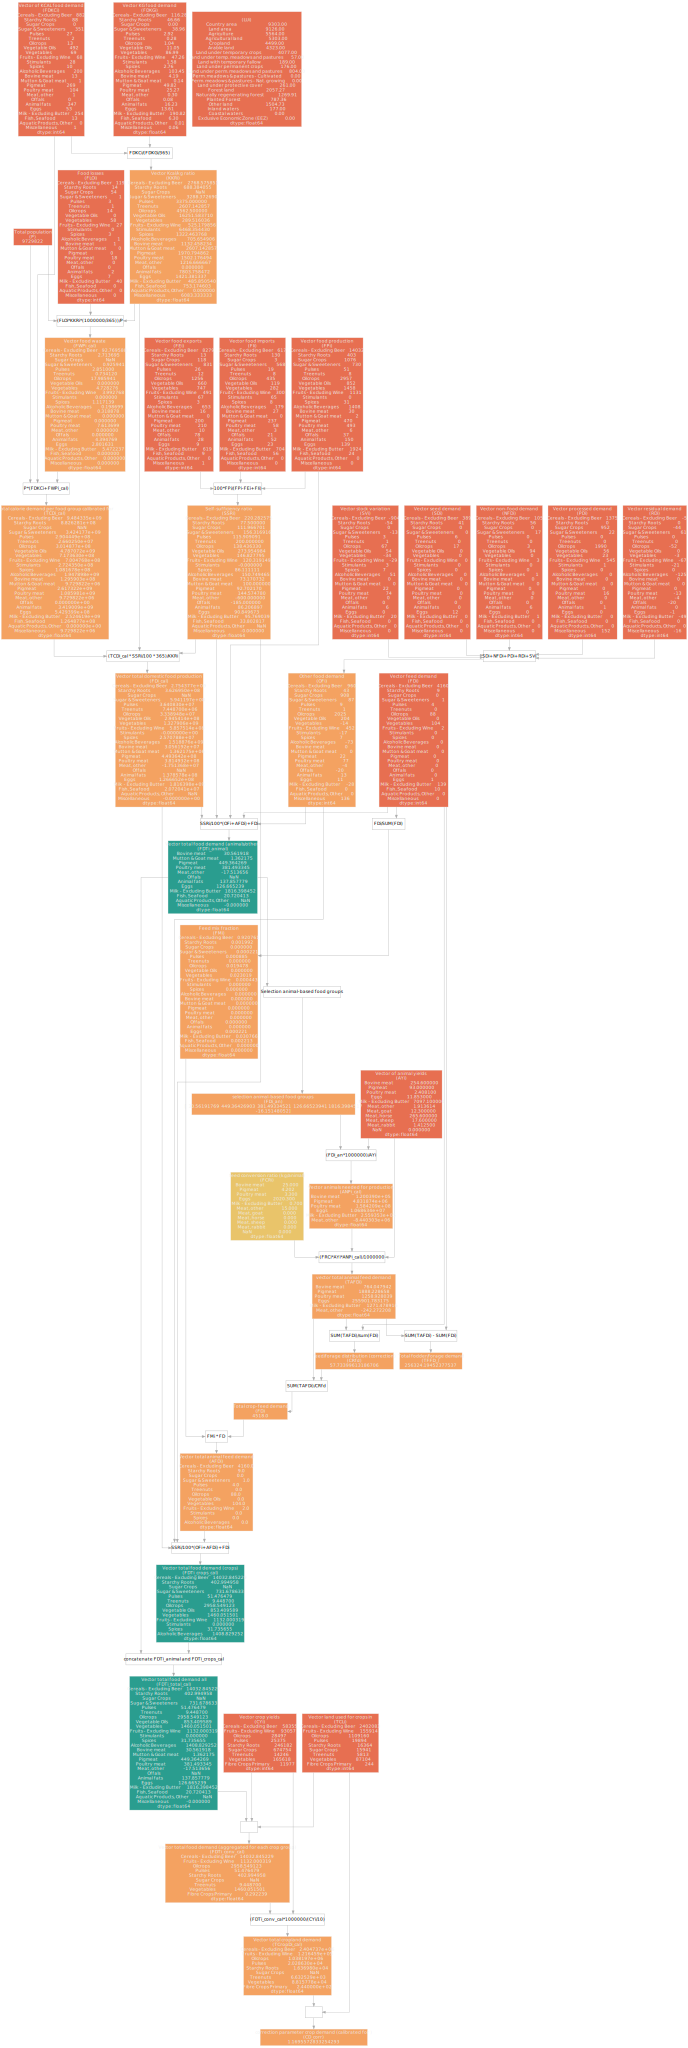

In [30]:
G.draw_computation(parameters, parameters)